## Project: Breast Ultrasound Image Segmentation

This notebook is dedicated to the critical task of **breast ultrasound image segmentation**. The primary objective is to accurately segment cancerous regions (lesions) within ultrasound images, which is a crucial step in the early detection and diagnosis of breast cancer.

### Dataset
We utilize the **Breast Ultrasound Images Dataset** from KaggleHub. This dataset comprises breast ultrasound images along with their corresponding ground truth masks for benign, malignant, and normal cases, enabling supervised training for segmentation tasks.

### Methodology
The segmentation model developed in this notebook employs an **Attention U-Net with Inception Blocks**. This architecture combines the strengths of the U-Net for biomedical image segmentation, attention mechanisms to focus on salient features, and Inception blocks for capturing multi-scale features, leading to enhanced segmentation performance and robustness.

# Import Required Libraries


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, concatenate,
                                     BatchNormalization, Activation, MaxPooling2D,
                                     Dropout, SpatialDropout2D, Multiply, Add)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from PIL import Image

# 1. DATA LOADING


In [2]:
import kagglehub

path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


In [3]:
categories = ['benign', 'malignant']#, 'normal']

data = []

for category in categories:
    category_path = os.path.join(path, 'Dataset_BUSI_with_GT', category)

    for filename in os.listdir(category_path):
        if filename.endswith('.png') and '_mask' not in filename:  # Exclude mask images
            file_path = os.path.join(category_path, filename)
            data.append({'image_path': file_path, 'label': category})

df = pd.DataFrame(data)
df.head()

,image_path,label
0,/kaggle/input/breast-ultrasound-images-dataset...,benign
1,/kaggle/input/breast-ultrasound-images-dataset...,benign
2,/kaggle/input/breast-ultrasound-images-dataset...,benign
3,/kaggle/input/breast-ultrasound-images-dataset...,benign
4,/kaggle/input/breast-ultrasound-images-dataset...,benign


In [4]:
df.shape

(647, 2)

In [5]:
data_dir = os.path.join(path, 'Dataset_BUSI_with_GT')
image_paths, mask_paths, labels = [], [], []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if file.endswith('.png') and '_mask' not in file:
            image_path = os.path.join(folder_path, file)
            mask_path = os.path.join(folder_path, file.replace('.png', '_mask.png'))

            if os.path.exists(mask_path):
                image_paths.append(image_path)
                mask_paths.append(mask_path)
                labels.append(folder)

df = pd.DataFrame({'filepaths': image_paths, 'masks': mask_paths, 'labels': labels})
print(f"Total images: {len(image_paths)}")
print(f"Label distribution:\n{df['labels'].value_counts()}")

Total images: 780
Label distribution:
labels
benign       437
malignant    210
normal       133
Name: count, dtype: int64


Displays random images from each class

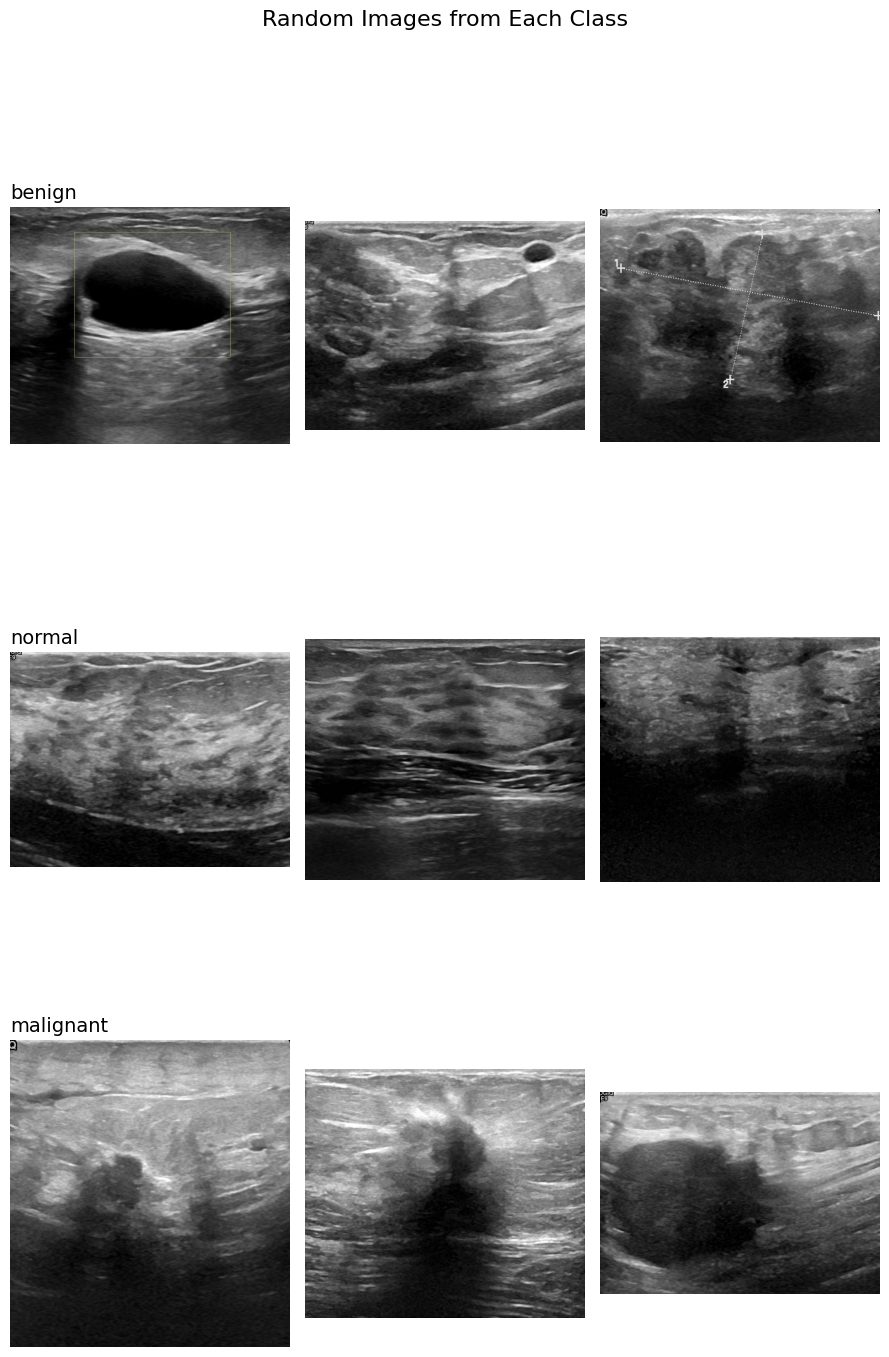

In [6]:
def display_random_images(df, num_images=3):
    """
    Displays a specified number of random images from each class in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'filepaths' and 'labels' columns.
    num_images (int): The number of random images to display for each class. Defaults to 3.

    Returns:
    None: The function displays a matplotlib plot.
    """
    # Unique labels (classes)
    classes = df['labels'].unique()
    num_classes = len(classes)

    # Set up the plot
    fig, axs = plt.subplots(num_classes, num_images, figsize=(9, 5 * num_classes))
    fig.suptitle('Random Images from Each Class', fontsize=16)

    for i, label in enumerate(classes):
        # Filter the DataFrame for the current label
        class_df = df[df['labels'] == label]

        # Randomly sample images for the current class
        sampled_images = class_df.sample(num_images)['filepaths'].values

        for j, filepath in enumerate(sampled_images):
            # Load and display the image
            img = Image.open(filepath)
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(label, loc='left', fontsize=14)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


# Call the function with your DataFrame
display_random_images(df, num_images=3)

# 2. AUGMENTATION


In [ ]:
train_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.GridDistortion(p=0.3),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3),
    A.CLAHE(clip_limit=4.0, p=0.4),   
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.Blur(blur_limit=3, p=0.2),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3)   
])

val_augmentor = A.Compose([
    A.CLAHE(clip_limit=4.0, p=1.0) 
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-684567050.py:6: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
/tmp/ipython-input-684567050.py:8: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3),
/tmp/ipython-input-684567050.py:11: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.3),
/tmp/ipython-input-684567050.py:13: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3)  # Cutout augmentation


In [8]:
def preprocess_image(image, target_size=256):
    """Enhanced preprocessing with better normalization.

    Resizes an image to a target size and converts it to uint8 format for augmentation.

    Parameters:
    image (numpy.ndarray): The input image to be preprocessed.
    target_size (int): The desired size for both width and height of the image. Defaults to 256.

    Returns:
    numpy.ndarray: The preprocessed image, resized and converted to uint8.

    Raises:
    ValueError: If the input image is None or has a size of 0.
    """
    if image is None or image.size == 0:
        raise ValueError("Invalid image detected")

    # Resize to target size
    image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_LANCZOS4)

    # Convert to uint8 for augmentation
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image

In [9]:
def load_data(dataset_path, augment=False, augmentor=None):
    """Improved data loading with better error handling"""
    images, masks = [], []
    classes = ['normal', 'benign', 'malignant']

    for class_name in classes:
        folder_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(folder_path):
            continue

        for file_name in os.listdir(folder_path):
            if '_mask' not in file_name and file_name.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, file_name)
                mask_path = os.path.join(folder_path, file_name.split('.')[0] + '_mask.png')

                if os.path.exists(mask_path):
                    try:
                        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                        if image is None or mask is None:
                            continue

                        # Preprocess
                        image = preprocess_image(image)
                        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
                        mask = (mask > 127).astype(np.uint8)

                        # Apply augmentation
                        if augment and augmentor:
                            augmented = augmentor(image=image, mask=mask)
                            image = augmented["image"]
                            mask = augmented["mask"]

                        images.append(image)
                        masks.append(mask)

                    except Exception as e:
                        print(f"Error loading {file_name}: {e}")
                        continue

    images = np.array(images).astype(np.float32) / 255.0
    masks = np.expand_dims(np.array(masks), axis=-1).astype(np.float32)

    return images, masks

In [10]:
print("Loading training data with augmentation...")
X_train_aug, y_train_aug = load_data(data_dir, augment=True, augmentor=train_augmentor)

print("Loading validation/test data...")
X_orig, y_orig = load_data(data_dir, augment=False)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Loading training data with augmentation...
Loading validation/test data...


In [11]:
X_val_processed, y_val_processed = [], []
for img, mask in zip(X_val, y_val):
    img_uint8 = (img * 255).astype(np.uint8)
    augmented = val_augmentor(image=img_uint8, mask=mask.squeeze().astype(np.uint8))
    X_val_processed.append(augmented['image'] / 255.0)
    y_val_processed.append(np.expand_dims(augmented['mask'], axis=-1).astype(np.float32)) # Convert to float32 here

X_val = np.array(X_val_processed)
y_val = np.array(y_val_processed)

In [12]:
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (624, 256, 256, 3)
Validation set: (78, 256, 256, 3)
Test set: (78, 256, 256, 3)


# 3. ADVANCED METRICS


In [13]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    """Calculates the Intersection Over Union (IoU) metric.

    IoU is a common evaluation metric for semantic segmentation, measuring the
    overlap between the ground truth and predicted segmentation masks.

    Parameters:
    y_true (tf.Tensor): The ground truth segmentation mask (binary).
    y_pred (tf.Tensor): The predicted segmentation mask (binary or probability map).
    smooth (float): A small constant to prevent division by zero. Defaults to 1e-6.

    Returns:
    tf.Tensor: The IoU score.
    """
    # Flatten the true and predicted masks for element-wise operations
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Calculate the intersection (where both are 1)
    intersection = K.sum(y_true_f * y_pred_f)

    # Calculate the union (where either is 1), subtracting intersection to avoid double counting
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    # Return the IoU score, adding smooth to numerator and denominator
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculates the Dice Coefficient (F1-score) for segmentation.

    The Dice Coefficient is a statistical measure of similarity between two
    binary images.

    Parameters:
    y_true (tf.Tensor): The ground truth segmentation mask (binary).
    y_pred (tf.Tensor): The predicted segmentation mask (binary or probability map).
    smooth (float): A small constant to prevent division by zero. Defaults to 1e-6.

    Returns:
    tf.Tensor: The Dice Coefficient score.
    """
    # Flatten the true and predicted masks
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Calculate the intersection
    intersection = K.sum(y_true_f * y_pred_f)

    # Calculate the Dice Coefficient: 2 * (intersection) / (sum of elements in y_true + sum of elements in y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Calculates the Dice Loss, which is 1 minus the Dice Coefficient.

    This loss function is particularly useful for highly imbalanced segmentation tasks.

    Parameters:
    y_true (tf.Tensor): The ground truth segmentation mask.
    y_pred (tf.Tensor): The predicted segmentation mask.

    Returns:
    tf.Tensor: The Dice Loss value.
    """
    return 1 - dice_coefficient(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75):
    """Calculates the Focal Tversky Loss.

    This loss function combines Tversky index with Focal Loss, making it suitable
    for highly imbalanced datasets, especially when false negatives are more critical.

    Parameters:
    y_true (tf.Tensor): The ground truth segmentation mask.
    y_pred (tf.Tensor): The predicted segmentation mask.
    alpha (float): Weighting factor for false negatives (controls trade-off between precision and recall).
                   Higher alpha means more penalty for false negatives. Defaults to 0.7.
    gamma (float): Focusing parameter (similar to Focal Loss) to down-weight easy examples.
                   Higher gamma increases the focus on hard-to-classify examples. Defaults to 0.75.

    Returns:
    tf.Tensor: The Focal Tversky Loss value.
    """
    # Flatten the true and predicted masks
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Calculate true positives, false negatives, and false positives
    true_pos = K.sum(y_true_f * y_pred_f)
    false_neg = K.sum(y_true_f * (1 - y_pred_f))
    false_pos = K.sum((1 - y_true_f) * y_pred_f)

    # Calculate the Tversky Index
    tversky = (true_pos + 1e-6) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + 1e-6)

    # Apply the focal component
    return K.pow(1 - tversky, gamma)

def combined_loss(y_true, y_pred):
    """Combines Focal Tversky Loss and Dice Loss.

    This combination leverages the strengths of both loss functions for robust
    segmentation, especially in cases with class imbalance.

    Parameters:
    y_true (tf.Tensor): The ground truth segmentation mask.
    y_pred (tf.Tensor): The predicted segmentation mask.

    Returns:
    tf.Tensor: The combined loss value.
    """
    return 0.5 * focal_tversky_loss(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# 4. IMPROVED ARCHITECTURE - Attention U-Net with Inception Blocks


In [ ]:
K.clear_session()

def attention_gate(x, g, inter_channels):
    """Attention gate for focusing on relevant features.

    This function implements an attention mechanism that helps the model
    focus on salient regions in the input feature maps (x) guided by
    the gating signal (g). It aims to suppress irrelevant regions.

    Parameters:
    x (tf.Tensor): The input feature map from a skip connection in the U-Net encoder.
                   Typically has higher spatial resolution and richer spatial information.
    g (tf.Tensor): The gating signal from a deeper layer in the U-Net decoder.
                   Typically has lower spatial resolution but richer contextual information.
    inter_channels (int): The number of intermediate channels used in the convolutional layers
                          within the attention gate.

    Returns:
    tf.Tensor: The attended feature map, where relevant features from 'x' are highlighted
               based on the gating signal 'g'. The output has the same shape as 'x'.
    """
    # Project the skip connection features (x) to a lower dimension, halving spatial dimensions
    theta_x = Conv2D(inter_channels, (1, 1), strides=(2, 2), padding='same')(x)
    # Project the gating signal (g) to a lower dimension, matching spatial dimensions of theta_x
    phi_g = Conv2D(inter_channels, (1, 1), strides=(2, 2), padding='same')(g)

    # Combine the projected features and gating signal using element-wise addition
    concat = Add()([theta_x, phi_g])
    # ReLU activation
    act = Activation('relu')(concat)

    # Generate attention coefficients
    psi = Conv2D(1, (1, 1), padding='same')(act)

    # Sigmoid activation
    psi = Activation('sigmoid')(psi)

    # Upsample the attention map to match the spatial dimensions of the input feature map 'x'
    upsample = Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same')(psi)

    # Apply the attention coefficients to the input feature map 'x' element-wise
    return Multiply()([x, upsample])

In [ ]:
def inception_block_v2(x, filters):
    """Enhanced inception block with batch norm and better initialization.

    This Inception block variant aims to capture multi-scale features by processing
    the input through different sized convolutional filters and pooling operations
    in parallel, then concatenating their outputs.

    Parameters:
    x (tf.Tensor): The input feature map to the Inception block.
    filters (int): The base number of filters used for the convolutional layers
                   within the block. Filters are typically divided by 4 for each branch.

    Returns:
    tf.Tensor: The concatenated output of all branches, representing multi-scale features.
    """
    # 1x1 convolution branch
    branch1 = Conv2D(filters // 4, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('relu')(branch1)

    # 1x1 convolution followed by 3x3 convolution branch
    branch2 = Conv2D(filters // 4, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)
    branch2 = Conv2D(filters // 4, (3, 3), padding='same', kernel_initializer='he_normal')(branch2)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)

    # 1x1 convolution followed by 5x5 convolution branch
    branch3 = Conv2D(filters // 4, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = Conv2D(filters // 4, (5, 5), padding='same', kernel_initializer='he_normal')(branch3)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)

    # 3x3 Max Pooling followed by 1x1 convolution branch
    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(filters // 4, (1, 1), padding='same', kernel_initializer='he_normal')(branch4)
    branch4 = BatchNormalization()(branch4)
    branch4 = Activation('relu')(branch4)

    # Concatenate all branch outputs along the channel dimension
    output = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

def attention_inception_unet(input_shape, filters=32, dropout_rate=0.3):
    """Attention Inception U-Net with residual connections.

    This model combines the U-Net architecture for segmentation with Inception blocks
    for multi-scale feature extraction and Attention Gates to focus on relevant features.

    Parameters:
    input_shape (tuple): The shape of the input images (height, width, channels).
    filters (int): The base number of filters for the first layer in the U-Net encoder.
                   This number is multiplied for deeper layers.
    dropout_rate (float): The dropout rate applied in SpatialDropout2D layers to prevent overfitting.

    Returns:
    tf.keras.Model: A compiled Keras model instance of the Attention Inception U-Net.
    """
    inputs = Input(input_shape)

    # Encoder Path
    # Block 1
    c1 = inception_block_v2(inputs, filters)
    c1 = inception_block_v2(c1, filters)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = SpatialDropout2D(dropout_rate * 0.5)(p1) # Apply dropout after pooling

    # Block 2
    c2 = inception_block_v2(p1, filters * 2)
    c2 = inception_block_v2(c2, filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = SpatialDropout2D(dropout_rate * 0.7)(p2)

    # Block 3
    c3 = inception_block_v2(p2, filters * 4)
    c3 = inception_block_v2(c3, filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = SpatialDropout2D(dropout_rate)(p3)

    # Block 4
    c4 = inception_block_v2(p3, filters * 8)
    c4 = inception_block_v2(c4, filters * 8)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = SpatialDropout2D(dropout_rate)(p4)

    # Bottleneck
    c5 = inception_block_v2(p4, filters * 16)
    c5 = inception_block_v2(c5, filters * 16)

    # Decoder Path with Attention Gates
    # Expansive Block 1 (from bottleneck to c4 level)
    u6 = Conv2DTranspose(filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    a6 = attention_gate(c4, u6, filters * 4) # Apply attention on skip connection c4, guided by u6
    u6 = concatenate([u6, a6]) # Concatenate upsampled feature map with attended skip connection
    u6 = SpatialDropout2D(dropout_rate)(u6)
    c6 = inception_block_v2(u6, filters * 8)
    c6 = inception_block_v2(c6, filters * 8)

    # Expansive Block 2 (from c6 to c3 level)
    u7 = Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    a7 = attention_gate(c3, u7, filters * 2) # Apply attention on skip connection c3, guided by u7
    u7 = concatenate([u7, a7])
    u7 = SpatialDropout2D(dropout_rate * 0.7)(u7)
    c7 = inception_block_v2(u7, filters * 4)
    c7 = inception_block_v2(c7, filters * 4)

    # Expansive Block 3 (from c7 to c2 level)
    u8 = Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    a8 = attention_gate(c2, u8, filters) # Apply attention on skip connection c2, guided by u8
    u8 = concatenate([u8, a8])
    u8 = SpatialDropout2D(dropout_rate * 0.5)(u8)
    c8 = inception_block_v2(u8, filters * 2)
    c8 = inception_block_v2(c8, filters * 2)

    # Expansive Block 4 (from c8 to c1 level)
    u9 = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(c8)
    a9 = attention_gate(c1, u9, filters // 2) # Apply attention on skip connection c1, guided by u9
    u9 = concatenate([u9, a9])
    u9 = SpatialDropout2D(dropout_rate * 0.5)(u9)
    c9 = inception_block_v2(u9, filters)
    c9 = inception_block_v2(c9, filters)

    # Output layer: 1x1 convolution with sigmoid activation for binary segmentation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create and return the Keras model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# 5. MODEL COMPILATION & CALLBACKS


In [16]:
input_size = (256, 256, 3)
model = attention_inception_unet(input_size, filters=32, dropout_rate=0.3)

# Use Adam with learning rate scheduling
initial_lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)

model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=[iou_metric, dice_coefficient, 'accuracy']
)

model.summary()

callbacks = [
    EarlyStopping(
        monitor='val_iou_metric',
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │         32 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │         32 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │         32 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        584 │ activation_1[0][… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │      1,608 │ activation_3[0][… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │         32 │ max_pooling2d[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat

 Total params: 4,315,549 (16.46 MB)

 Trainable params: 4,306,717 (16.43 MB)

 Non-trainable params: 8,832 (34.50 KB)

# 6. TRAINING


In [17]:
print("\n" + "="*50)
print("Starting Training with Improved Architecture")
print("="*50 + "\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


Starting Training with Improved Architecture

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6687 - dice_coefficient: 0.1483 - iou_metric: 0.0807 - loss: 0.8458 - val_accuracy: 0.1390 - val_dice_coefficient: 0.1533 - val_iou_metric: 0.0834 - val_loss: 0.8332 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 605ms/step - accuracy: 0.6519 - dice_coefficient: 0.2322 - iou_metric: 0.1327 - loss: 0.7584 - val_accuracy: 0.1644 - val_dice_coefficient: 0.1568 - val_iou_metric: 0.0855 - val_loss: 0.8295 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 609ms/step - accuracy: 0.7852 - dice_coefficient: 0.2807 - iou_metric: 0.1655 - loss: 0.7138 - val_accuracy: 0.4651 - val_dice_coefficient: 0.1855 - val_iou_metric: 0.1029 - val_loss: 0.8029 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 604ms/step - accuracy: 0.8270 - dice_coefficient: 0.3367 - iou_metric: 0.2058 - loss: 0.6659 - val_accuracy: 0.8112 - val_dice_coefficient

# 7. EVALUATION & VISUALIZATION


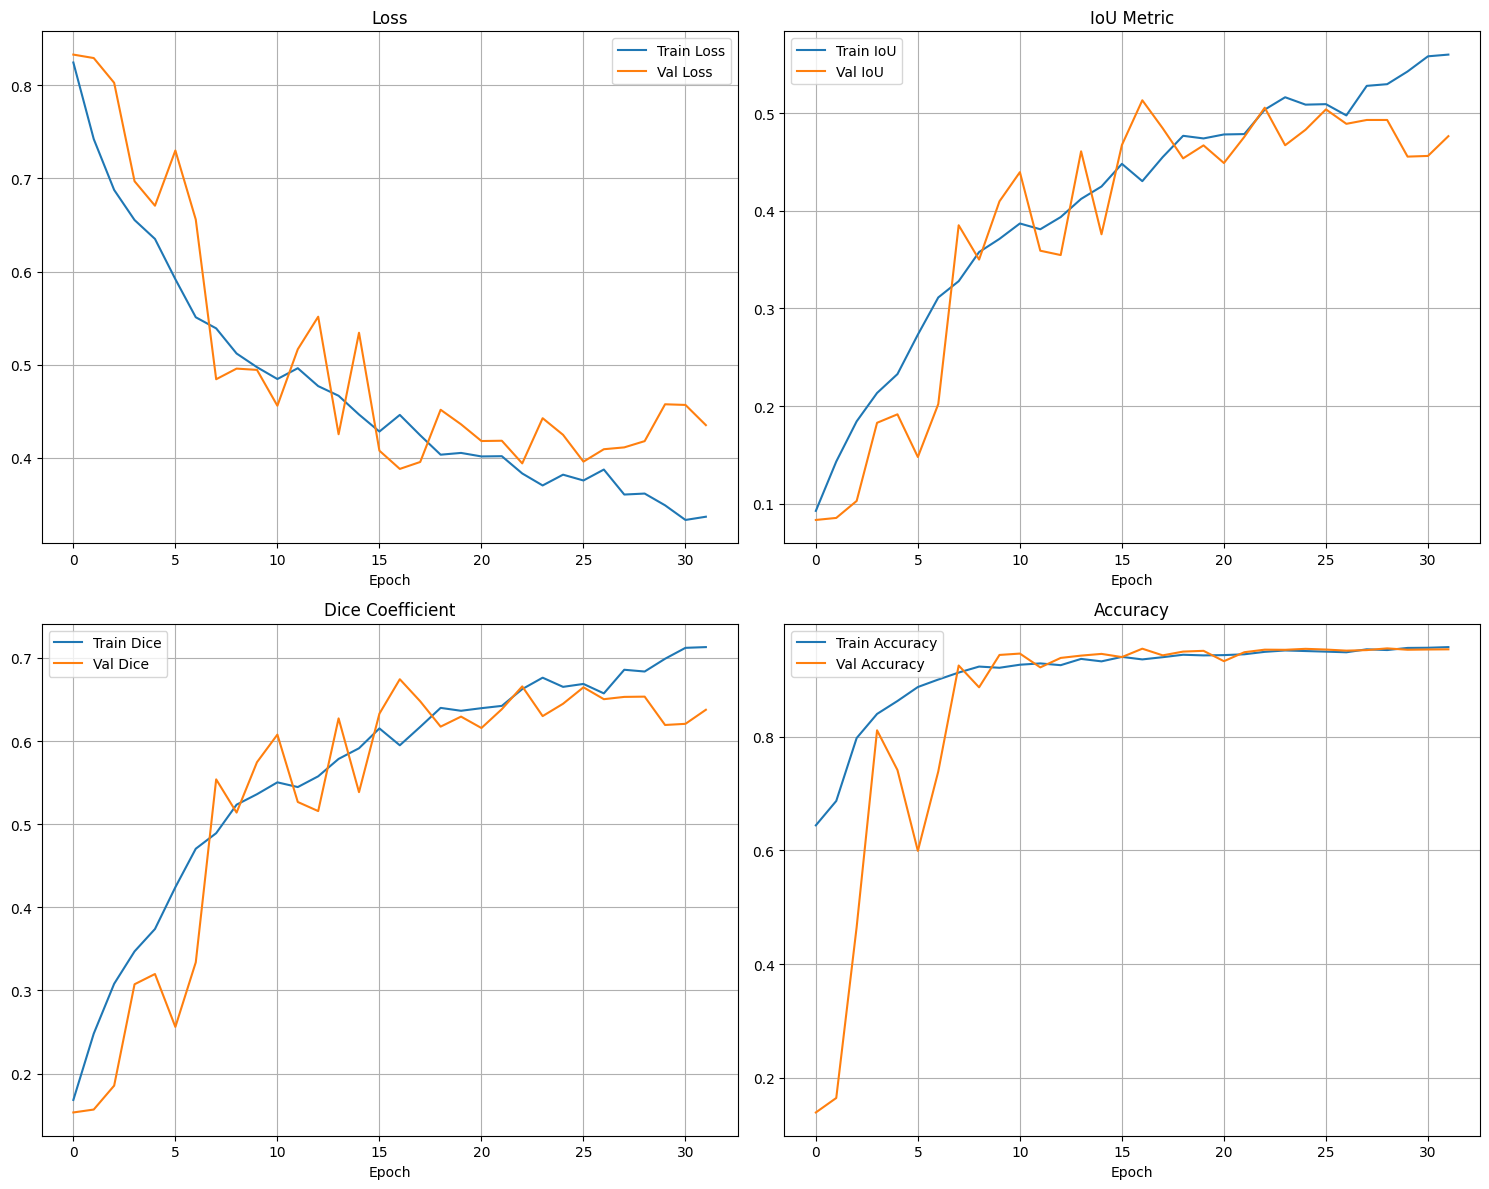

In [18]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history.history['iou_metric'], label='Train IoU')
axes[0, 1].plot(history.history['val_iou_metric'], label='Val IoU')
axes[0, 1].set_title('IoU Metric')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history.history['dice_coefficient'], label='Train Dice')
axes[1, 0].plot(history.history['val_dice_coefficient'], label='Val Dice')
axes[1, 0].set_title('Dice Coefficient')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/filoger/training_history.png', dpi=300, bbox_inches='tight')
plt.show()


Test Set Evaluation
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.9281 - dice_coefficient: 0.6494 - iou_metric: 0.4822 - loss: 0.3795

Test Loss: 0.3916
Test IoU: 0.4597
Test Dice: 0.6283
Test Accuracy: 0.9249
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


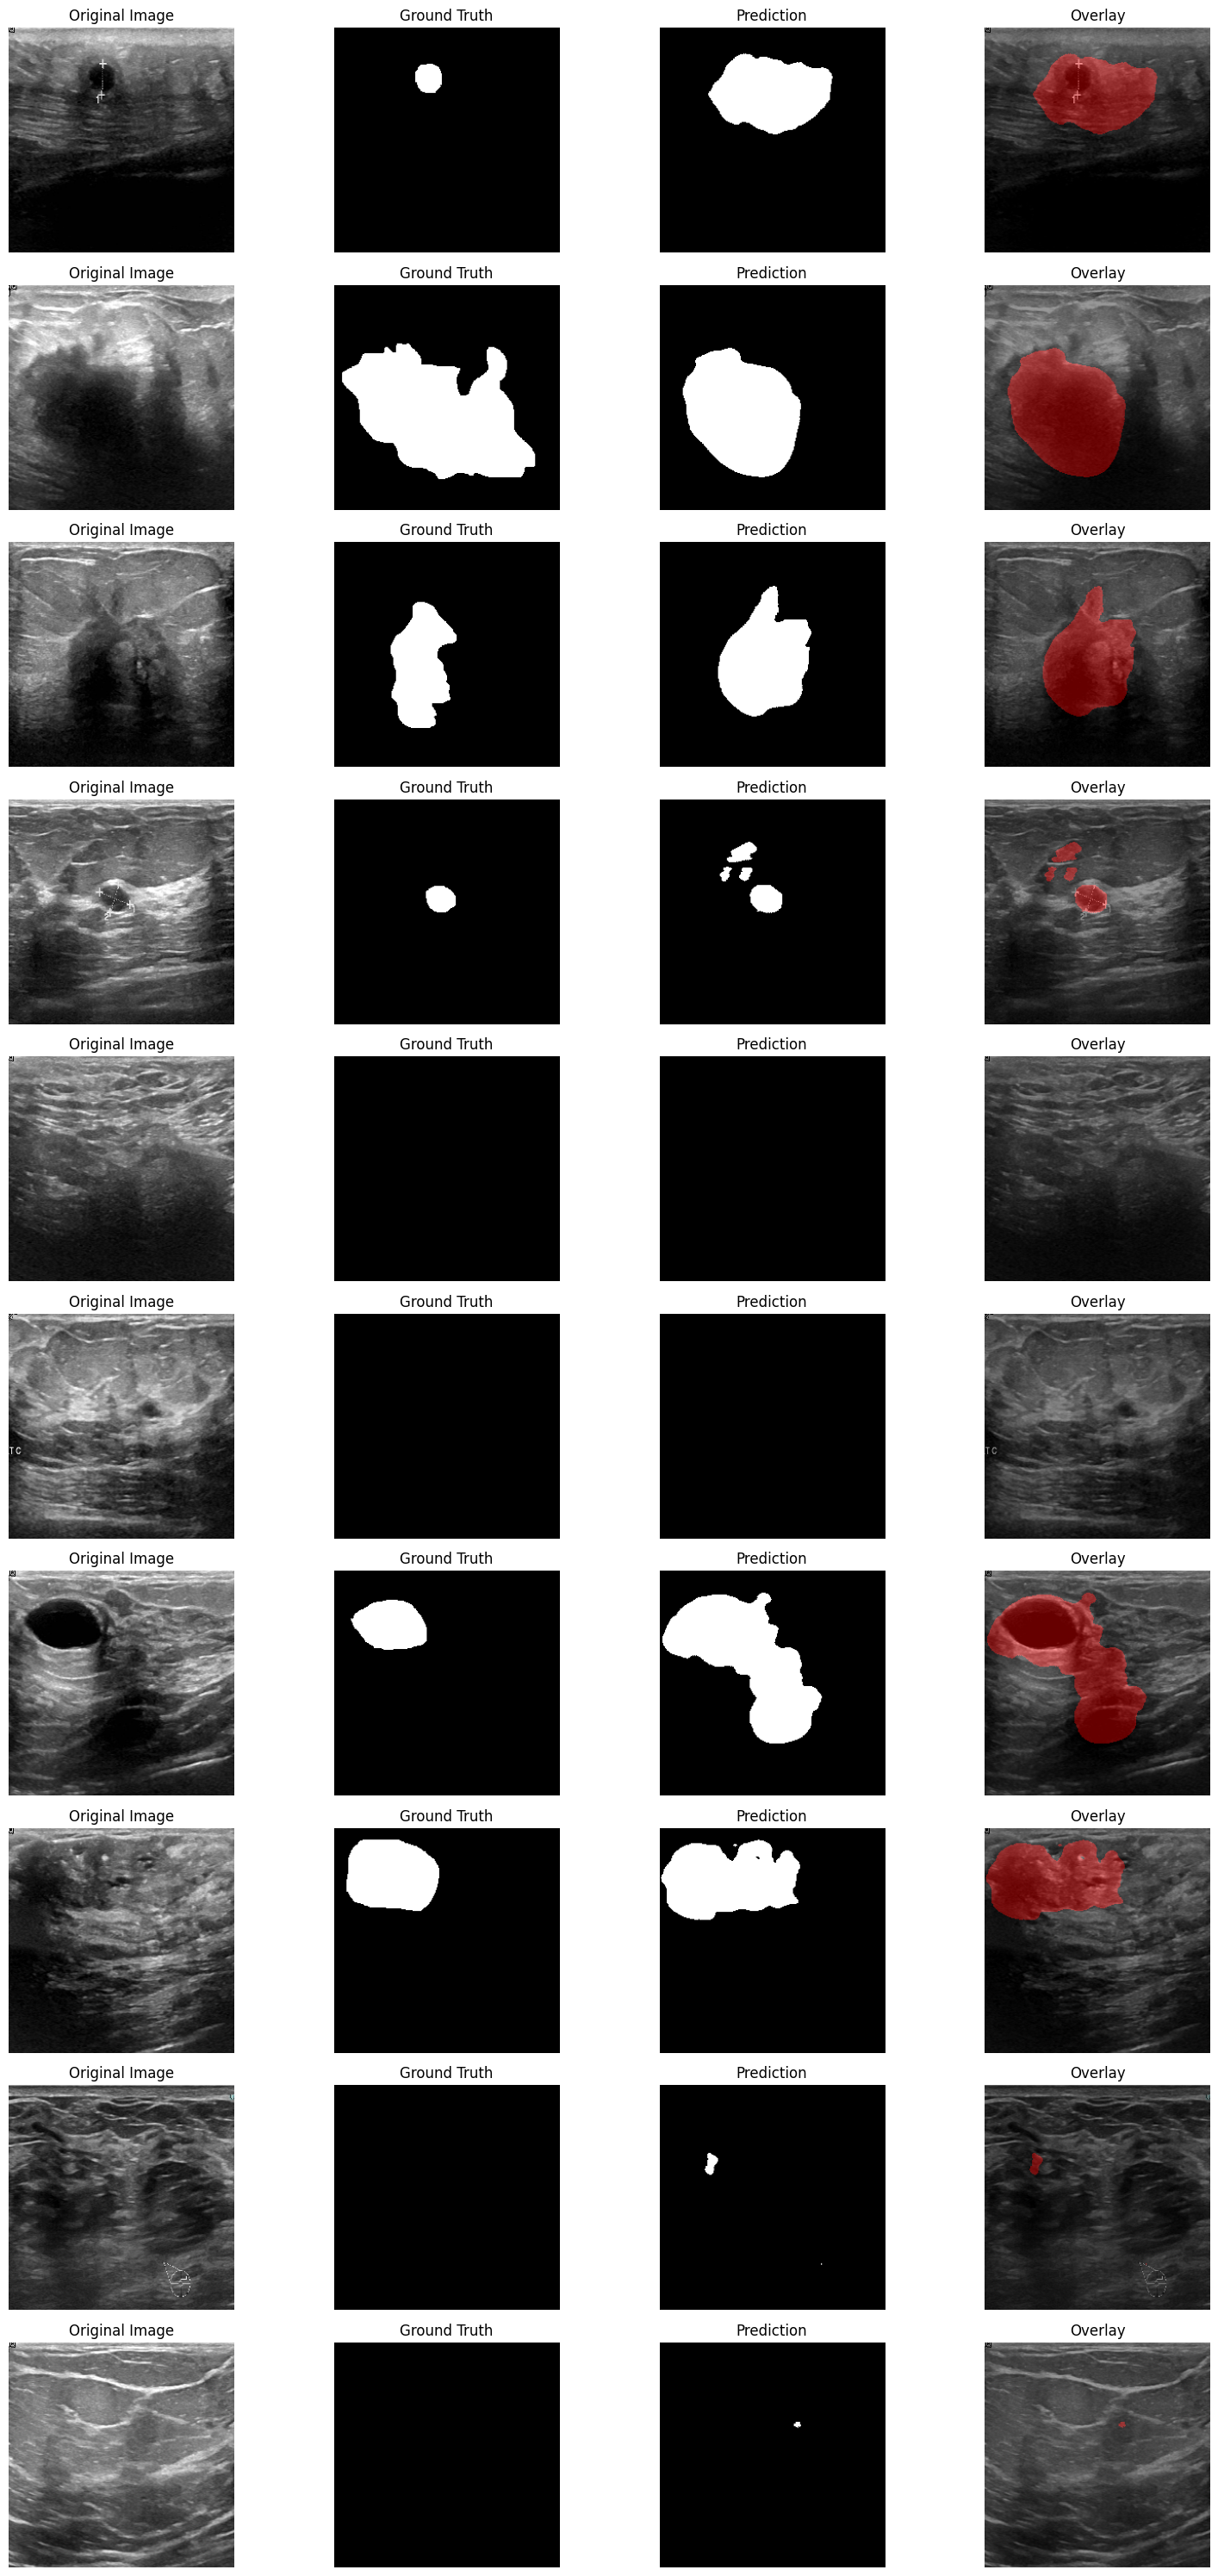

In [19]:
# Test evaluation
print("\n" + "="*50)
print("Test Set Evaluation")
print("="*50)
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Loss: {test_results[0]:.4f}")
print(f"Test IoU: {test_results[1]:.4f}")
print(f"Test Dice: {test_results[2]:.4f}")
print(f"Test Accuracy: {test_results[3]:.4f}")

# Visualize predictions
threshold = 0.5
num_samples = 10
samples = X_test[:num_samples]
true_masks = y_test[:num_samples]
predicted_masks = model.predict(samples)

fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
for i in range(num_samples):
    # Original image
    axes[i, 0].imshow(samples[i])
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Ground truth
    axes[i, 1].imshow(true_masks[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    # Prediction
    binary_mask = (predicted_masks[i] > threshold).astype(np.uint8)
    axes[i, 2].imshow(binary_mask.squeeze(), cmap='gray')
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

    # Overlay
    overlay = samples[i].copy()
    mask_rgb = np.zeros_like(overlay)
    mask_rgb[:, :, 0] = binary_mask.squeeze() * 255  # Red channel
    axes[i, 3].imshow(overlay)
    axes[i, 3].imshow(mask_rgb, alpha=0.4)
    axes[i, 3].set_title('Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

